### 载入数据

In [1]:
import sys
import pickle
sys.path.append(r"G:\Udacity 数据分析（进阶）\P5 机器学习\ud120-projects-master\tools")
sys.path.append(r"G:\Udacity 数据分析（进阶）\P5 机器学习\最终项目") # ‘final_project_dataset.pkl’在该文件夹下
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data,test_classifier
import matplotlib.pyplot
from sklearn.feature_selection import SelectPercentile,SelectKBest
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)


D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 理解数据集

#### 数据点总数为146；特征总数为20；poi数量为18，非poi数量为128，该数据集非常不平衡，所以最终评估时应该使用Recall和Precision指标；有很多特征都存在缺失值

In [2]:

# 数据点总数
print("数据点总数",len(data_dict))

# 特征总数
print("特征总数",len(data_dict['HANNON KEVIN P'])-1)

data_poi = []
data_nan = []

for i in data_dict:    
    # poi及非poi数量
    if data_dict[i]['poi'] == True:
        data_poi.append(i)
        
    # 哪些特征存在缺失值
    for ii,jj in data_dict[i].items():
        if jj == "NaN":
            data_nan.append(ii)

print("poi数量",len(data_poi))
print("非poi数量",len(data_dict)-len(data_poi))


数据点总数 146
特征总数 20
poi数量 18
非poi数量 128


### 构造新特征

#### 在特征选择时会对新特征性能进行测试

In [3]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

def fraction(poi,all):
    if all == 'NaN':
        fraction_poi = 0
    else:
        fraction_poi = poi/all
    return fraction_poi

for i in data_dict:
    my_dataset[i]['fraction_from_poi'] = fraction(my_dataset[i]['from_poi_to_this_person'],my_dataset[i]['to_messages'])
    my_dataset[i]['fraction_to_poi'] = fraction(my_dataset[i]['from_this_person_to_poi'],my_dataset[i]['from_messages'])


### 清除异常值

#### 通过可视化，发现异常值为“TOTAL”，遂将其删除。此外还有“THE TRAVEL AGENCY IN THE PARK”，其不是一个人；“LOCKHART EUGENE E”其值全为‘NaN’

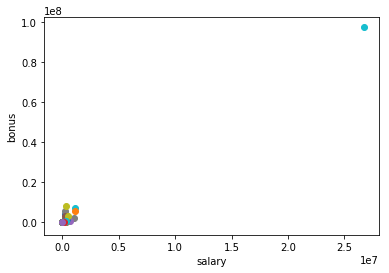

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'fraction_from_poi': 0,
 'fraction_to_poi': 0,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

In [4]:
### Task 2: Remove outliers
%matplotlib inline

features_list = ['poi','salary','bonus','total_payments','deferral_payments','exercised_stock_options',\
                     'restricted_stock','restricted_stock_deferred','total_stock_value','expenses',\
                     'other','director_fees','loan_advances','deferred_income','long_term_incentive',\
                     'from_poi_to_this_person','from_this_person_to_poi','to_messages','from_messages',\
                     'shared_receipt_with_poi','fraction_from_poi','fraction_to_poi'] # You will need to use more features

data = featureFormat(my_dataset, features_list,sort_keys=True)
labels, features = targetFeatureSplit(data)

for point in data:
    salary = point[1]
    bonus = point[2]
    matplotlib.pyplot.scatter( salary, bonus )
#     print(salary,bonus)
matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()
my_dataset.pop("TOTAL")
my_dataset.pop("LOCKHART EUGENE E")
my_dataset.pop("THE TRAVEL AGENCY IN THE PARK")

### 特征选择

#### 通过打印特征得分可以得出新特征得分分别为‘24.8’、‘24.2’、 ‘20.8’、‘18.3’、‘16.4’

In [5]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
data = featureFormat(my_dataset, features_list,sort_keys=True)
labels, features = targetFeatureSplit(data)

selector = SelectKBest(k=5)
selector.fit(features,labels)
features_new = selector.transform(features)

# 选取了表现最好的前5个feature
print(selector.scores_)

features_new.shape
features_new_list = [features_list[i+1] for i in selector.get_support(indices=True)]
features_new_list_poi = ['poi'] + features_new_list


print(features_new)

[ 18.28968404  20.79225205   8.77277773   0.22461127  24.81507973
   9.21281062   0.06549965  24.18289868   6.09417331   4.18747751
   2.1263278    7.18405566  11.45847658   9.92218601   5.24344971
   2.38261211   1.64634113   0.16970095   8.58942073   3.12809175
  16.40971255]
[[  2.01955000e+05   4.17500000e+06   1.72954100e+06   1.72954100e+06
    2.96127563e-02]
 [  0.00000000e+00   0.00000000e+00   2.57817000e+05   2.57817000e+05
    0.00000000e+00]
 [  4.77000000e+02   0.00000000e+00   4.04615700e+06   5.24348700e+06
    0.00000000e+00]
 [  2.67102000e+05   1.20000000e+06   6.68054400e+06   1.06232580e+07
    0.00000000e+00]
 [  2.39671000e+05   4.00000000e+05   0.00000000e+00   6.30140000e+04
    0.00000000e+00]
 [  8.08180000e+04   0.00000000e+00   1.59964100e+06   1.59964100e+06
    0.00000000e+00]
 [  2.31330000e+05   7.00000000e+05   0.00000000e+00   1.26027000e+05
    8.88786553e-02]
 [  2.13999000e+05   5.24999900e+06   9.53136000e+05   1.11070500e+06
    2.23140496e-01]
 

### 进行特征缩放

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# features = scaler.fit_transform(features_new)





### 用k折交叉验证划分训练集和测试集

In [31]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
# from sklearn.model_selection import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)

labels = np.asarray(labels)

# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit()

from sklearn.model_selection import KFold
kf = KFold(n_splits=2,shuffle=True)

# for train_index,test_index in kf.split(features):
#     print("TRAIN",train_index,'\n','TEST',test_index)
#     features_train, features_test = features[train_index], features[test_index]
#     labels_train, labels_test = labels[train_index], labels[test_index]

### 分类算法

#### SVM

In [34]:
%%time
from sklearn.svm import SVC
parms = {'svc__kernel':('linear','rbf'),'svc__C':[1.0,2.0]}
clf = SVC()

pipeline1 = Pipeline([('scaler',scaler),('svc',clf)])
# a = pipeline.fit(features_train,labels_train)
gs = GridSearchCV(pipeline1,parms,cv=kf)
gs.fit(features_new,labels)

clf = gs.best_estimator_

# clf = clf.fit(features_train,labels_train)
# clf = clf.best_estimator_
# pred = clf.predict(features_test)

print(clf.score(features_new,labels))




0.895104895105
Wall time: 33 ms


#### 测试得分

In [35]:
%%time
test_classifier(clf,my_dataset,features_new_list_poi)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86007	Precision: 0.90196	Recall: 0.02300	F1: 0.04486	F2: 0.02857
	Total predictions: 14000	True positives:   46	False positives:    5	False negatives: 1954	True negatives: 11995

Wall time: 1.27 s


#### 决策树

In [18]:
%%time
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

parms = {'rfc__n_estimators':range(10,40,10),'rfc__max_depth':range(3,9,2)}
clf = RandomForestClassifier()
# clf = DecisionTreeClassifier()

pipeline2 = Pipeline([('scaler',scaler),('rfc',clf)])
gs = GridSearchCV(pipeline2,parms,cv=kf)
gs.fit(features_new,labels)

clf = gs.best_estimator_

# pred = clf.predict(features_test)
print(clf.score(features_new,labels))


0.979020979021
Wall time: 3.11 s


#### 测试得分

In [19]:
%%time
test_classifier(clf,my_dataset,features_new_list_poi)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.85464	Precision: 0.48112	Recall: 0.22300	F1: 0.30475	F2: 0.24980
	Total predictions: 14000	True positives:  446	False positives:  481	False negatives: 1554	True negatives: 11519

Wall time: 43.3 s


#### 朴素贝叶斯

In [32]:

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
parm = {}

clf = Pipeline([('scaler',scaler),('gnb',clf)])
gs = GridSearchCV(clf,parm,cv=kf)
gs.fit(features_new,labels)

clf = gs.best_estimator_

# clf = clf.fit(features_train,labels_train)
# pred = clf.predict(features_test)
# clf.score(features_test,labels_test)

clf.score(features_new,labels)

0.88111888111888115

#### 测试得分

In [33]:

test_classifier(clf,my_dataset,features_new_list_poi)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('gnb', GaussianNB(priors=None))])
	Accuracy: 0.84879	Precision: 0.45558	Recall: 0.30000	F1: 0.36177	F2: 0.32199
	Total predictions: 14000	True positives:  600	False positives:  717	False negatives: 1400	True negatives: 11283



### 存储

In [14]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_new_list)